<a href="https://colab.research.google.com/github/serjisa/transcriptomics.msu/blob/main/%D0%A1%D0%B5%D0%BC%D0%B8%D0%BD%D0%B0%D1%80%D1%8B/03_%D0%9E%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5_%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Семинар 3. Определение максимально правдоподобных распределений для данных

Для того, чтобы корректно применять статистические тесты, а также выуживать из данных максимальное количество информации, которая в них хранится, необходимо точно понимать, по какому закону эти данные распределены.

На этом семинаре мы разберём, как корректно понять, что именно за распределение в данных мы наблюдаем. Для примера мы загрузим набор данных из ресурса <a href="https://jhubiostatistics.shinyapps.io">ReCount2</a> (в целом это полезный ресурс в случае, если вам необходимо загрузить из открытых источников именно RNA-Seq count data).

In [1]:
# Загрузка R magic
%load_ext rpy2.ipython

# Установка нужных пакетов
!Rscript -e 'install.packages("fitdistrplus", repos="https://cloud.r-project.org")'

# Загрузка датасета
#!gdown --id 1nlpCcK6LoqEJnvCqEdcUFNElZSoz_3Kg

пробую URL 'https://cloud.r-project.org/src/contrib/fitdistrplus_1.1-11.tar.gz'
Content type 'application/x-gzip' length 1551868 bytes (1.5 MB)
downloaded 1.5 MB

* installing *source* package ‘fitdistrplus’ ...
** пакет ‘fitdistrplus’ удачно распакован, MD5 sums проверены
** using staged installation
** R
** data
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (fitdistrplus)

Скачанные исходники пакетов находятся в
	‘/private/var/folders/7l/1krjf0t17kg9kff851ssct_c0000gn/T/RtmpnK1FO5/downloaded_packages’
Обновляю HTML-список пакетов в '.Library'
Making 'packages.html' ... готово


In [2]:
!gdown --id 1nlpCcK6LoqEJnvCqEdcUFNElZSoz_3Kg

/Users/m.trofimov/mambaforge/envs/biotools/lib/python3.11/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1nlpCcK6LoqEJnvCqEdcUFNElZSoz_3Kg
To: /Users/m.trofimov/Dropbox/Study/transcriptomics.msu/3_distributions_of_transcripts/LUAD_counts.tsv
100%|██████████████████████████████████████| 3.18M/3.18M [00:00<00:00, 4.96MB/s]


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import rpy2
# Настройка отображения
plt.rcParams["figure.dpi"] = 100

In [29]:
# Прочтение датасета
df = pd.read_csv("LUAD_counts.tsv", sep="\t")
df.index = [gene.split(".")[0] for gene in df.gene_name]
del df["gene_name"]
df = df.T

Первое, что необходимо сделать, &mdash; это посмотреть на распределение данных глазами, построив гистограмму.

<AxesSubplot: ylabel='Count'>

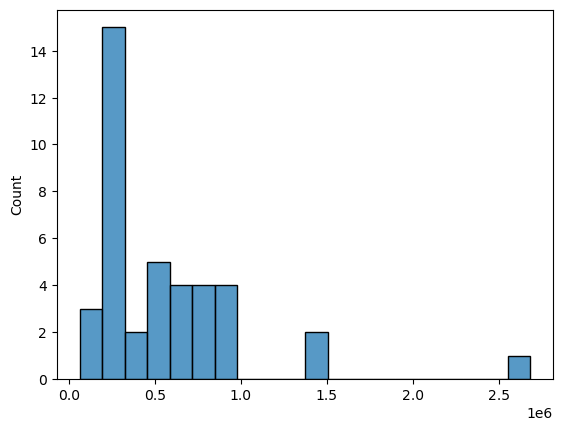

In [5]:
gene = "MT-CO1"
expr = np.array(df[gene])
sns.histplot(expr, bins=20)

В принципе похоже на нормальное распределение, не так ли? Легко можно представить, как именно на таких данных запускают классический t-test. Однако давайте оценим его нормальность при помощи классического теста, который проходят в университете.

In [6]:
from scipy.stats import shapiro

stat, p = shapiro(df[gene])
print(f"Statistics={stat:3f}, p={p:3f}")

Statistics=0.742976, p=0.000001


Уже не выглядит так, что данные нормальные, да? Как вообще понимают, какое распределение описывает данные лучше всего? Для начала разберёмся, как оценивают, хорошо ли описываются данные каким-то распределением. При помощи пакета <code>fitdistrplus</code> для R попробуем описать наши данные нормальным распределением и разберём, что конкретно происходило.

## Зависимость дисперсии от среднего

In [7]:
means = np.mean(df.values, axis=0)
vars = np.var(df.values, axis=0)

means = means[vars > 0]
vars = vars[vars > 0]

means = np.log10(means)
vars = np.log10(vars)

Text(0, 0.5, 'log$_{10}$(Variance)')

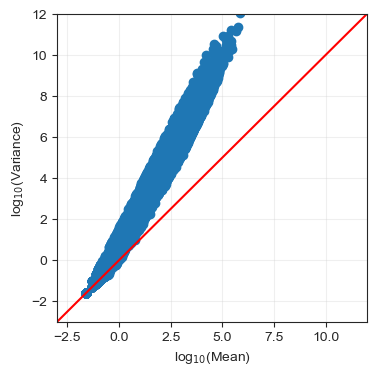

In [8]:
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(4, 4), dpi=100)

ax.scatter(means, vars)
ax.plot([-3, 12], [-3, 12], color="red")
ax.set_xlim(-3, 12)
ax.set_ylim(-3, 12)
ax.grid(alpha=0.3)

ax.set_xlabel("log$_{10}$(Mean)")
ax.set_ylabel("log$_{10}$(Variance)")

## Тестирование конкретного распределения

Допустим, мы знаем, что наш набор данных описывается нормальным распределением (или каким-либо иным параметрическим распределением). Но как определить, какие именно параметры такого распределения? Мы можем найти максимально правдоподобную оценку такого распределения.

In [9]:
%%R -i expr
library(fitdistrplus)

R[write to console]: Загрузка требуемого пакета: MASS

R[write to console]: Загрузка требуемого пакета: survival



In [10]:
%%R
data <- as.vector(expr)
fit.norm <- fitdist(data, "norm")
summary(fit.norm)

Fitting of the distribution ' norm ' by maximum likelihood 
Parameters : 
     estimate Std. Error
mean 553010.3          0
sd   464404.5          0
Loglikelihood:  -578.698   AIC:  1161.396   BIC:  1164.774 
Correlation matrix:
     mean  sd
mean    1 NaN
sd    NaN   1



In [11]:
%%R
data <- as.vector(expr)
fit.nbinom <- fitdist(data, "nbinom")
summary(fit.nbinom)

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 


         estimate Std. Error
size 1.990279e+00         NA
mu   5.528951e+05         NA
Loglikelihood:  -564.3479   AIC:  1132.696   BIC:  1136.074 
Correlation matrix:
[1] NA



Нарисуем графики для анализа:

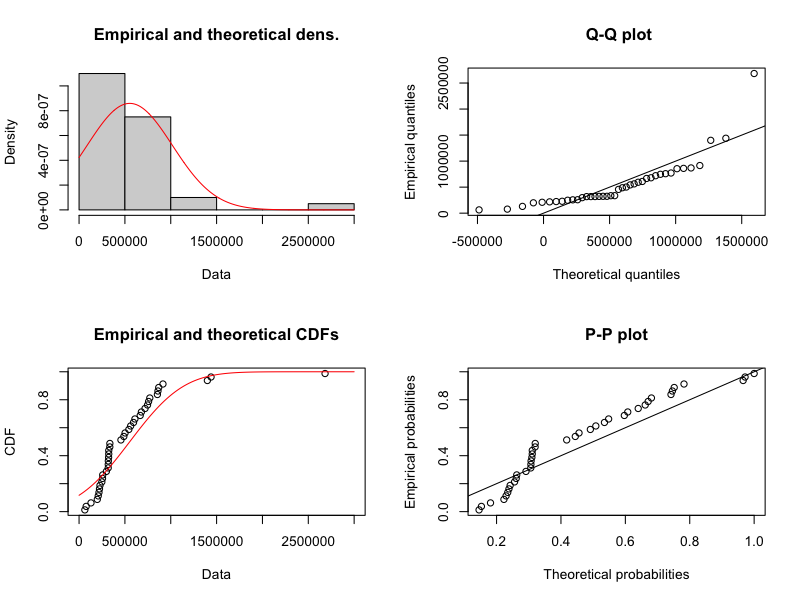

In [12]:
%%R -r 100 -w 800 -h 600
plot(fit.norm)

Пока будем ориентироваться только на правдоподобие того, что данные порождены этим распределением. Как вы думаете, у нас высокое или низкое значение правдоподобия?

### Задание

Сравните несколько распределений и определите, какое из них, по вашему мнению, лучше всего описывает данные. Для того, чтобы найти доступные для использования распределения, прочитайте документацию пакета по <a href="https://cran.r-project.org/web/packages/fitdistrplus/fitdistrplus.pdf">ссылке</a>.

## Сравнение тестов между собой

После того, как мы нашли Likelihood того, что наши данные порождены определённым распределением с определёнными параметрами, нам необходимо сравнить модели между собой, чтобы понять, какая из них описывает данные лучше. Казалось бы, можно сравнить правдоподобия и всё, однако у распределений есть ещё один важный параметр, который мы не учли, &mdash; это число параметров самой модели.

Для того, чтобы учитывать число параметров самой модели, существует информационный критерий Акаике
$\mathrm{AIC} = 2k – 2(\mathrm{LogLikelihood})$, где $k$ &mdash; это число параметров модели. И то распределение, которое будет иметь меньшее значение AIC, и будет более предпочтительным.

Посмотрим заново на результаты того, как мы зафитили нашу модель:

In [13]:
%%R
summary(fit.norm)

Fitting of the distribution ' norm ' by maximum likelihood 
Parameters : 
     estimate Std. Error
mean 553010.3          0
sd   464404.5          0
Loglikelihood:  -578.698   AIC:  1161.396   BIC:  1164.774 
Correlation matrix:
     mean  sd
mean    1 NaN
sd    NaN   1



Так же мы можем сравнить CDF нашего распределения и тех распределений, которые мы зафитили:

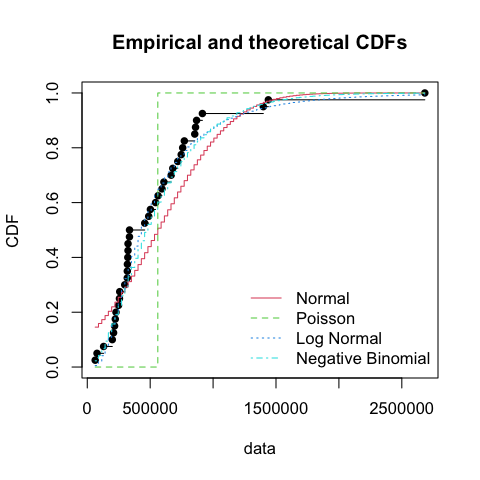

In [14]:
%%R -r 100
fit_n  <- fitdist(data, "norm")
fit_p  <- fitdist(data, "pois")
fit_nb  <- fitdist(data, "nbinom")
fit_ln  <- fitdist(data, "lnorm")
cdfcomp(list(fit_n, fit_p, fit_ln, fit_nb), legendtext = c("Normal", "Poisson", "Log Normal", "Negative Binomial"))

In [15]:
%%R
summary(fit_nb)

Fitting of the distribution ' nbinom ' by maximum likelihood 
Parameters : 
         estimate Std. Error
size 1.990279e+00         NA
mu   5.528951e+05         NA
Loglikelihood:  -564.3479   AIC:  1132.696   BIC:  1136.074 
Correlation matrix:
[1] NA



In [16]:
%%R
summary(fit_n)

Fitting of the distribution ' norm ' by maximum likelihood 
Parameters : 
     estimate Std. Error
mean 553010.3          0
sd   464404.5          0
Loglikelihood:  -578.698   AIC:  1161.396   BIC:  1164.774 
Correlation matrix:
     mean  sd
mean    1 NaN
sd    NaN   1



Также для того, чтобы оценить нестабильность наших данных, можно использовать бутстрэп.

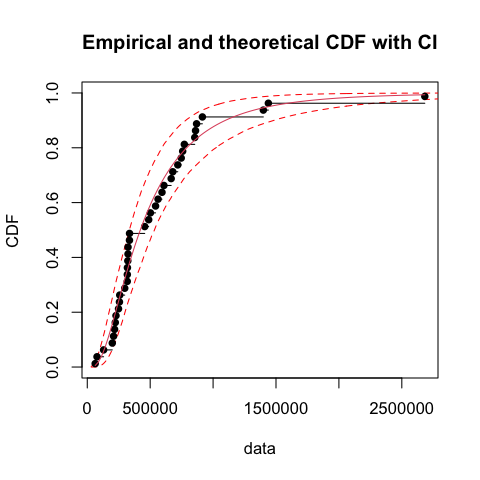

In [17]:
%%R -r 100
fit_ln.boot <- bootdist(fit_ln, "param")
CIcdfplot(fit_ln.boot, CI.output = "probability")

Или использовать оценки третьего и четвёртого моментов для того, чтобы хотя бы приблизительно понять, к какому распределению наши данные могут быть отнесены:

summary statistics
------
min:  62918   max:  2682832 
median:  396275.5 
mean:  553010.3 
estimated sd:  470320.8 
estimated skewness:  2.709948 
estimated kurtosis:  13.21073 


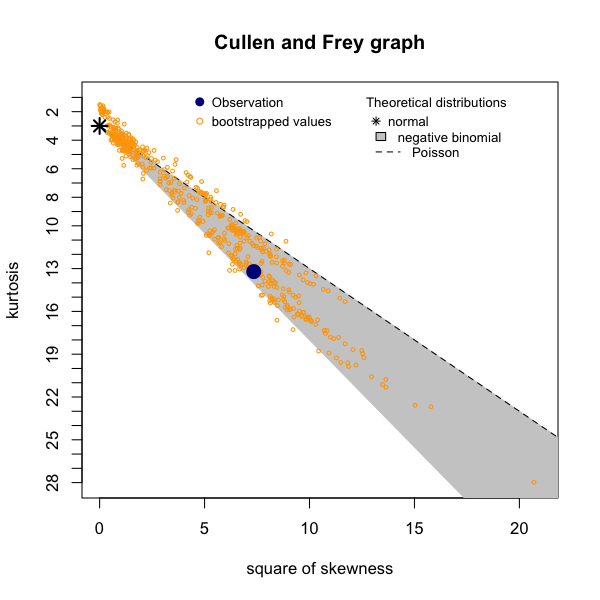

In [18]:
%%R -r 100 -w 600 -h 600
descdist(data, discrete=TRUE, boot=500)

## Домашнее задание

Определите максимально правдоподобное распределение для наших даных. Попробуйте это сделать на случайной выборке из экспрессий 30 других генов. Согласованный ли получился результат?

Скачайте датасет <code>1M8-86VecaYPERovPk4JKhT2lLa4PfJxi</code> из статьи <a href="https://bmcgenomics.biomedcentral.com/articles/10.1186/1471-2164-13-304#Sec8">Oberg et al., 2012</a>. Внимательно прочитайте статью и изучите дизайн эксперимента &mdash; какие реплики в статье называют техническими, а какие &mdash; биологическими? Правда ли в технических репликах наблюдается распределение Пуассона?

Проделайте подобную процедуру с каунтами генов, которые вы получили в результате анализа <a href="https://www.nature.com/articles/s41598-018-23226-4">статьи</a> со сравнением методов подготовки библиотек для scRNA-Seq (`1Mh2T7YyWG9LPQsuNGy_IdYhbbzUgZUek`). Разберитесь, что в случае этой работы называют технической репликой. Актуально ли распределение Пуассона в случае таких технических реплик?